In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib as mpl
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy
import pickle
import sys
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pacmap
from scipy.spatial.transform import Rotation as R

In [4]:
# Get RMSD between 2 curves 
def rmsd(vec1, vec2):
    vec1 = vec1.swapaxes(0,1).copy()
    vec2 = vec2.swapaxes(0,1).copy()
    rmsd = np.sqrt(((((vec1 - vec2)** 2))*3).mean())
    return rmsd


# Get a colour gradient to represent time 


def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

In [5]:
# Load in all actin positions at all % of time 

# The shape of all_actin_vectors_all_time is 101 timepoints * 20 fibers * 3 dimensions * 500 monomer points
x = np.loadtxt("positions.txt")
all_actin_vectors_all_time = x.reshape(101,20,3,500) 
print(all_actin_vectors_all_time)

[[[[-2.5000e-01 -2.4900e-01 -2.4800e-01 ...  2.4700e-01  2.4800e-01
     2.4900e-01]
   [ 0.0000e+00  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
     0.0000e+00]
   [ 0.0000e+00  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
     0.0000e+00]]

  [[-2.5000e-01 -2.4900e-01 -2.4800e-01 ...  2.4700e-01  2.4800e-01
     2.4900e-01]
   [ 0.0000e+00  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
     0.0000e+00]
   [ 0.0000e+00  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
     0.0000e+00]]

  [[-2.5000e-01 -2.4900e-01 -2.4800e-01 ...  2.4700e-01  2.4800e-01
     2.4900e-01]
   [ 0.0000e+00  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
     0.0000e+00]
   [ 0.0000e+00  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
     0.0000e+00]]

  ...

  [[-2.5000e-01 -2.4900e-01 -2.4800e-01 ...  2.4700e-01  2.4800e-01
     2.4900e-01]
   [ 0.0000e+00  0.0000e+00  0.0000e+00 ...  0.0000e+00  0.0000e+00
     0.0000e+00]
   [ 0.0000e+00  0.0000e+00  0.0000e+00 ...  0.0000e

In [8]:
# Reshape the np array to use scipy rotation. Also select a ref fiber between (2000-2020, i.e. last time point) to 
# align all the fibers into the same plane 
x = np.array(all_actin_vectors_all_time) 
a = np.ravel(x)
to_align = a.reshape((2020,3,500))
ref = to_align[2019].copy() # Reference curve 


In [9]:
# Rotate the fibers around the x axis to achieve optimal alignment based on RMSD, by creating a linspace and checking every possible rotation 
# Store the best rotation in align_by

align_by = []

for i in range(len(to_align)):
    
    best_rmsd = 100000000
    best_angle = 10000000
    for j in np.linspace(0,2*np.pi,1000):
        r = R.from_rotvec(j * np.array([1, 0, 0]))
        new_vec = scipy.spatial.transform.Rotation.apply(r, to_align[i].swapaxes(0,1).copy())
        new_vec = new_vec.swapaxes(0,1)

        if(rmsd(new_vec,ref) < best_rmsd):
                best_rot = j
                best_rmsd = rmsd(new_vec,ref)
    align_by.append(best_rot)
                
        
print(len(align_by))

2020


In [10]:

#align all the different curves to ref 
aligned = []
for i in range(len(to_align)):
    a = to_align[i].swapaxes(0,1).copy()
    r = R.from_rotvec(align_by[i] * np.array([1, 0, 0]))
    new_vec = scipy.spatial.transform.Rotation.apply(r, a)
    new_vec = new_vec.swapaxes(0,1)
    aligned.append(new_vec)

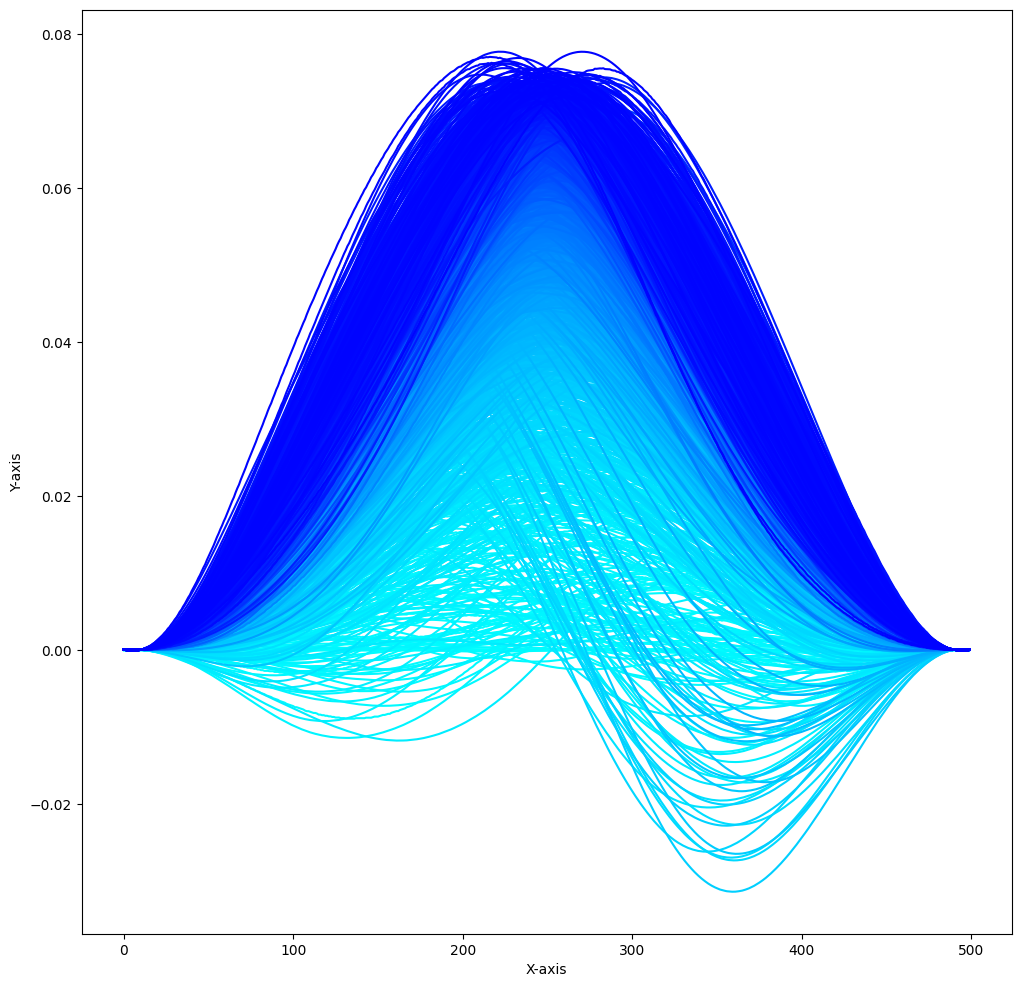

In [12]:
# Plot the x,y positions to check alignment

c1='cyan' 
c2='blue' 

colors = []
for i in range(101):
    colors.append(colorFader(c1,c2,i/101))
    
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()


for i in range(len(aligned)):
    
    idx = i//20
    plt.plot(aligned[i][2],color = colors[idx])

    

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

ax.ticklabel_format(useOffset=False, style='plain')

# PCA analyis 

In [13]:
pca_dataset = np.array(aligned)
pca_dataset = pca_dataset.reshape((2020,1500))
x = pca_dataset
pca = PCA(n_components=2)
pcs = pca.fit_transform(x)

print(pca.explained_variance_ratio_)

[0.95664284 0.02619931]


In [14]:
principalDf = pd.DataFrame(data = pcs, columns = ['principal component 1', 'principal component 2'])

sims = []
for i in range(2020):
    if(i%20 < 5):
        sims.append(4.7)
    elif (i%20 < 10):
        sims.append(15)
    elif (i%20 < 15):
        sims.append(150)
    else:
        sims.append(47)
        
        
time = [] 
for i in range(2020):
    t = (i//20)
    time.append(t)

    
principalDf["label"] = sims 
principalDf["time"] = time


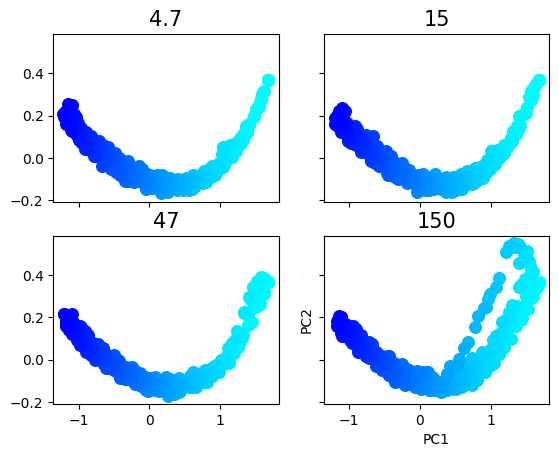

In [15]:
fig,ax = plt.subplots(2,2,sharex = True, sharey = True)
targets = range(0,101)
runs = [4.7,15,47,150]



ax[1][1].set_xlabel("PC1")
ax[1][1].set_ylabel("PC2")

for i in range(2):
    for j in range(2):
        ax[i][j].set_title(str(runs[2*i+j]), fontsize = 15)






for i in range(len(targets)):
    for j in range(len(runs)):
        col = colors[i]
        indicesToKeep = ((principalDf['time'] == targets[i]) & (principalDf["label"] == runs[j]))
        ax[j//2][j%2].scatter(principalDf.loc[indicesToKeep, 'principal component 1']
           , principalDf.loc[indicesToKeep, 'principal component 2'], c = col, s = 70)


# Perform inverse transform on the second component


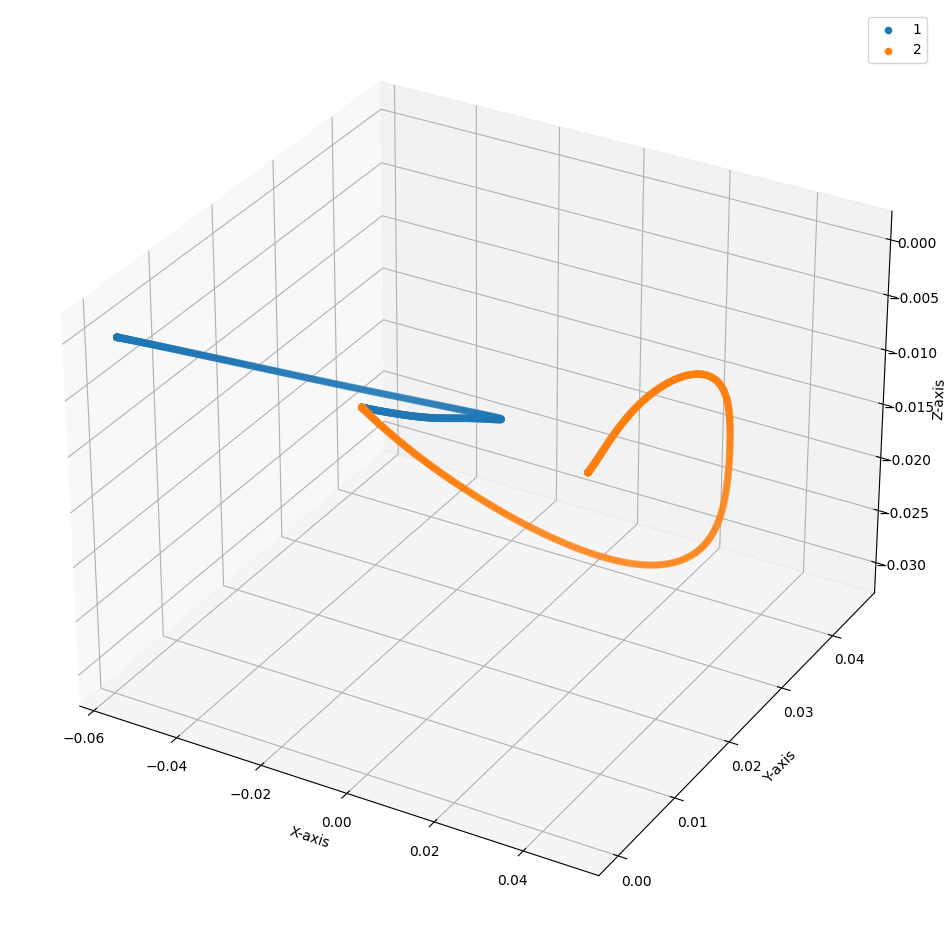

In [16]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
count = 1
for comps in pca.components_:
    label = str(count)
    x_axis = comps[0:500]
    y_axis = comps[500:1000]
    z_axis = comps[1000:1500]
    count += 1 

    ax.scatter(x_axis,y_axis,z_axis, label = label)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
# ax.view_init(elev=0, azim=0, roll=270)
ax.ticklabel_format(useOffset=False, style='plain')
ax.legend()

# PACMAP


In [19]:
embedding = pacmap.PaCMAP(n_components=2, n_neighbors =5) 
X_transformed = embedding.fit_transform(x, init="pca")
y = np.array(sims)
principalDf = pd.DataFrame(data = X_transformed, columns = ['pacmap component 1', 'pacmap component 2'])
principalDf["label"] = sims 
principalDf["time"] = time

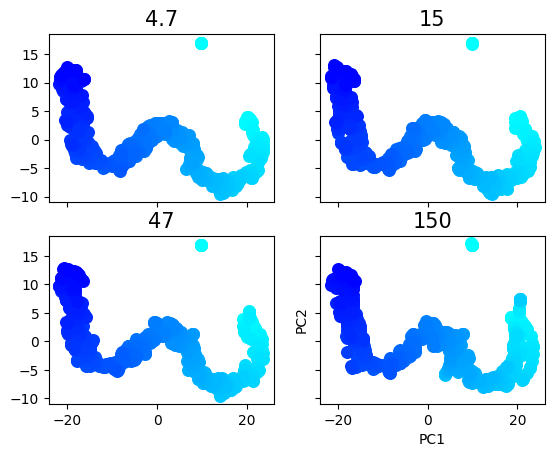

In [20]:
fig,ax = plt.subplots(2,2,sharex = True, sharey = True)
targets = range(0,101)
runs = [4.7,15,47,150]



ax[1][1].set_xlabel("PC1")
ax[1][1].set_ylabel("PC2")

for i in range(2):
    for j in range(2):
        ax[i][j].set_title(str(runs[2*i+j]), fontsize = 15)






for i in range(len(targets)):
    for j in range(len(runs)):
        col = colors[i]
        indicesToKeep = ((principalDf['time'] == targets[i]) & (principalDf["label"] == runs[j]))
        ax[j//2][j%2].scatter(principalDf.loc[indicesToKeep, 'pacmap component 1']
           , principalDf.loc[indicesToKeep, 'pacmap component 2'], c = col, s = 70)